# 1. Preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import glob

img_paths = glob.glob('./img_align_celeba/*.jpg')
len(img_paths)

57572

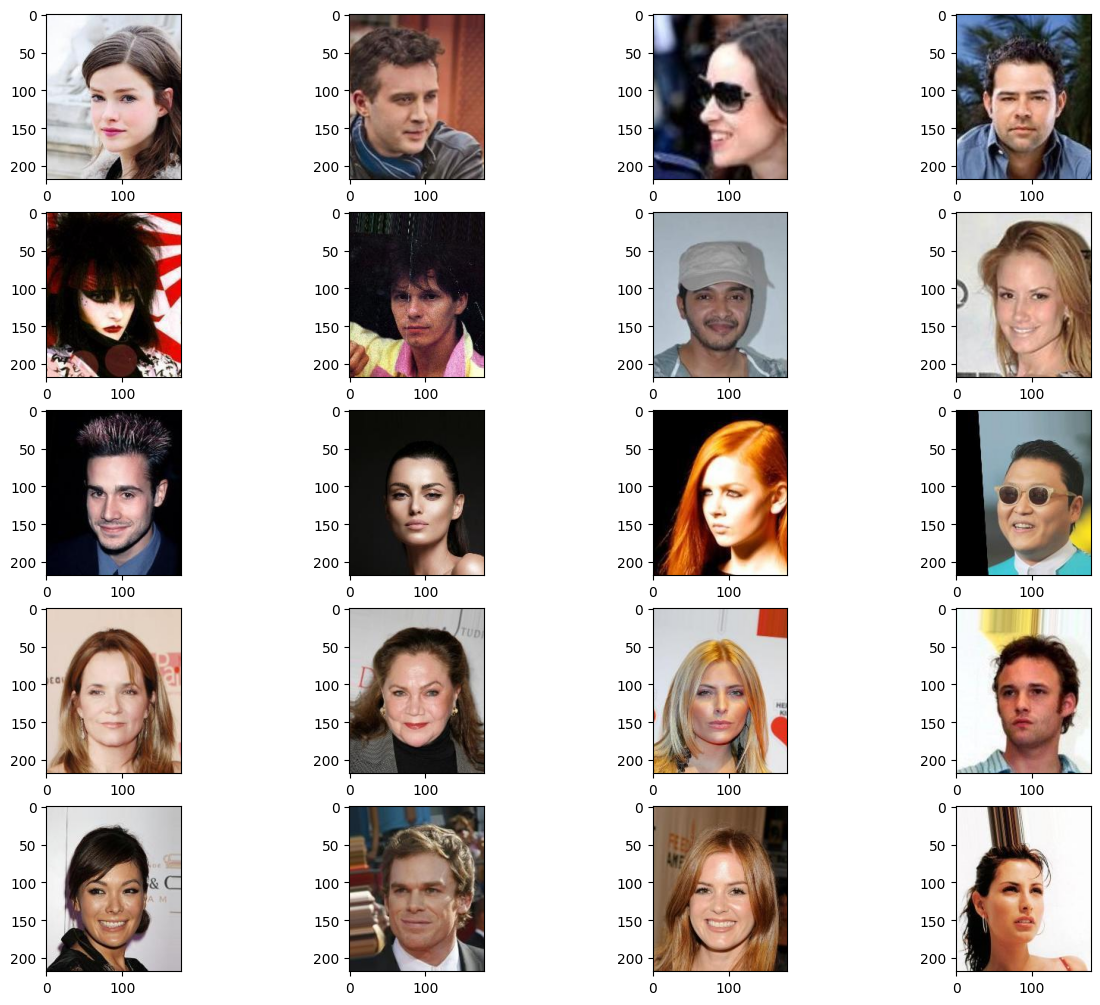

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_images(file_names, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img_path in enumerate(img_paths):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img_np)
show_images(img_paths)

In [ ]:
num_train, num_val = 2304, 576 # demo with small data
train_imgpaths = img_paths[ : num_train]
val_imgpaths = img_paths[num_train : num_train+num_val]

In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

class ColorDataset():
    def __init__(self, img_paths, data_len=2880, image_size=(128, 128)):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths
        self.tfs = transforms.Resize((image_size[0], image_size[1]))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        arr_img_bgr = cv2.imread(img_path)
        arr_img_lab = cv2.cvtColor(arr_img_bgr, cv2.COLOR_BGR2LAB)
        arr_img_lab = ((arr_img_lab * 2.0) / 255.0) - 1.0
        tens_img_lab = torch.tensor(arr_img_lab.transpose(2, 0, 1), dtype=torch.float32)
        tens_img_lab = self.tfs(tens_img_lab)
        tens_img_l = tens_img_lab[:1, :, :]
        tens_img_ab = tens_img_lab[1:, :, :]
        return tens_img_l, tens_img_ab

    def __len__(self):
        return len(self.img_paths)

In [ ]:
train_dataset = ColorDataset(train_imgpaths)
val_dataset = ColorDataset(val_imgpaths)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 48
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
a = iter(train_loader)
b, c = next(a)
print(b.shape)
print(c.shape)

torch.Size([48, 1, 128, 128])
torch.Size([48, 2, 128, 128])


# 2. Build UNet model

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)



def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += torch.DoubleTensor([matmul_ops])


def gamma_embedding(gammas, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param gammas: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=gammas.device)
    args = gammas[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from abc import abstractmethod

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class EmbedBlock(nn.Module):
    """
    Any module where forward() takes embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` embeddings.
        """

class EmbedSequential(nn.Sequential, EmbedBlock):
    """
    A sequential module that passes embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, EmbedBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.

    """

    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(self.channels, self.out_channel, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        stride = 2
        if use_conv:
            self.op = nn.Conv2d(
                self.channels, self.out_channel, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_channel
            self.op = nn.AvgPool2d(kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(EmbedBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of embedding channels.
    :param dropout: the rate of dropout.
    :param out_channel: if specified, the number of out channels.
    :param use_conv: if True and out_channel is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channel=None,
        use_conv=False,
        use_scale_shift_norm=False,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            SiLU(),
            nn.Conv2d(channels, self.out_channel, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channel if use_scale_shift_norm else self.out_channel,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channel),
            SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv2d(self.out_channel, self.out_channel, 3, padding=1)
            ),
        )

        if self.out_channel == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv2d(
                channels, self.out_channel, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channel, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)

class UNet(nn.Module):
    """
    The full UNet model with attention and embedding.
    :param in_channel: channels in the input Tensor, for image colorization : Y_channels + X_channels .
    :param inner_channel: base channel count for the model.
    :param out_channel: channels in the output Tensor.
    :param res_blocks: number of residual blocks per downsample.
    :param attn_res: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mults: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channel,
        inner_channel,
        out_channel,
        res_blocks,
        attn_res,
        dropout=0,
        channel_mults=(1, 2, 4, 8),
        conv_resample=True,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=False,
    ):

        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channel = in_channel
        self.inner_channel = inner_channel
        self.out_channel = out_channel
        self.res_blocks = res_blocks
        self.attn_res = attn_res
        self.dropout = dropout
        self.channel_mults = channel_mults
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = torch.float16 if use_fp16 else torch.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        cond_embed_dim = inner_channel * 4
        self.cond_embed = nn.Sequential(
            nn.Linear(inner_channel, cond_embed_dim),
            SiLU(),
            nn.Linear(cond_embed_dim, cond_embed_dim),
        )

        ch = input_ch = int(channel_mults[0] * inner_channel)
        self.input_blocks = nn.ModuleList(
            [EmbedSequential(nn.Conv2d(in_channel, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mults):
            for _ in range(res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        cond_embed_dim,
                        dropout,
                        out_channel=int(mult * inner_channel),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * inner_channel)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mults) - 1:
                out_ch = ch
                self.input_blocks.append(
                    EmbedSequential(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, out_channel=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = EmbedSequential(
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mults))[::-1]:
            for i in range(res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        cond_embed_dim,
                        dropout,
                        out_channel=int(inner_channel * mult),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(inner_channel * mult)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, out_channel=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            SiLU(),
            zero_module(nn.Conv2d(input_ch, out_channel, 3, padding=1)),
        )

    def forward(self, x, gammas):
        """
        Apply the model to an input batch.
        :param x: an [N x 2 x ...] Tensor of inputs (B&W)
        :param gammas: a 1-D batch of gammas.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        gammas = gammas.view(-1, )
        emb = self.cond_embed(gamma_embedding(gammas, self.inner_channel))

        h = x.type(torch.float32)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

## Test

In [ ]:
batch_size, h, w = 5, 64, 64
timsteps = 100
model = UNet(
    image_size=h,
    in_channel=3,
    inner_channel=64,
    out_channel=2,
    res_blocks=2,
    attn_res=[8]
)
color = torch.randn((batch_size, 2, h, w))
gray = torch.randn((batch_size, 1, h, w))
input = torch.concat([gray, color], dim=1)
emb = torch.ones((batch_size, ))
print(input.shape)
print(emb.shape)
out = model(input, emb)
print(out.shape)

torch.Size([5, 3, 64, 64])
torch.Size([5])
torch.Size([5, 2, 64, 64])


# 3. Build Color-Diffusion model

In [ ]:
def make_beta_schedule(schedule, n_timestep, linear_start=1e-5, linear_end=1e-2):
    if schedule == 'linear':
        betas = np.linspace(
            linear_start, linear_end, n_timestep, dtype=np.float64
        )
    else:
        raise NotImplementedError(schedule)
    return betas

def get_index_from_list(vals, t, x_shape=(1,1,1,1)):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size, *_ = t.shape
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device)

In [ ]:
from tqdm import tqdm
from functools import partial

class ColorDiffusion(nn.Module):
    def __init__(self, unet_config, beta_schedule, **kwargs):
        super(ColorDiffusion, self).__init__(**kwargs)
        self.denoise_fn = UNet(**unet_config)
        self.beta_schedule = beta_schedule

    def set_new_noise_schedule(self, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)
        betas = make_beta_schedule(**self.beta_schedule)
        alphas = 1. - betas
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        gammas = np.cumprod(alphas, axis=0) # alphas_cumprod
        gammas_prev = np.append(1., gammas[:-1])

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('gammas', to_torch(gammas))
        self.register_buffer('sqrt_recip_gammas', to_torch(np.sqrt(1. / gammas)))
        self.register_buffer('sqrt_recipm1_gammas', to_torch(np.sqrt(1. / gammas - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - gammas_prev) / (1. - gammas)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(betas * np.sqrt(gammas_prev) / (1. - gammas)))
        self.register_buffer('posterior_mean_coef2', to_torch((1. - gammas_prev) * np.sqrt(alphas) / (1. - gammas)))

    def set_loss(self, loss_fn):
        self.loss_fn = loss_fn

    def predict_start_from_noise(self, y_t, t, noise):
        return (
            get_index_from_list(self.sqrt_recip_gammas, t, y_t.shape) * y_t -
            get_index_from_list(self.sqrt_recipm1_gammas, t, y_t.shape) * noise
        )

    def q_posterior(self, y_0_hat, y_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        posterior_mean = (
            get_index_from_list(self.posterior_mean_coef1, t, y_t.shape) * y_0_hat +
            get_index_from_list(self.posterior_mean_coef2, t, y_t.shape) * y_t
        )
        posterior_log_variance_clipped = get_index_from_list(
            self.posterior_log_variance_clipped, t, y_t.shape
        )
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, y_t, t, clip_denoised: bool, y_cond=None):
        noise_level = get_index_from_list(self.gammas, t, x_shape=(1, 1)).to(y_t.device)
        y_0_hat = self.predict_start_from_noise(
                y_t, t=t, noise=self.denoise_fn(torch.cat([y_cond, y_t], dim=1), noise_level))

        if clip_denoised:
            y_0_hat.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            y_0_hat=y_0_hat, y_t=y_t, t=t)
        return model_mean, posterior_log_variance

    def q_sample(self, y_0, sample_gammas, noise=None):
        noise = noise if noise is not None else torch.randn_like(y_0)
        return (
            sample_gammas.sqrt() * y_0 +
            (1 - sample_gammas).sqrt() * noise
        )

    @torch.no_grad()
    def p_sample(self, y_t, t, clip_denoised=True, y_cond=None):
        model_mean, model_log_variance = self.p_mean_variance(
            y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond)
        noise = torch.randn_like(y_t) if any(t>0) else torch.zeros_like(y_t)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def restoration(self, y_cond, y_t=None, y_0=None, sample_num=8):
        b, _, h, w = y_cond.shape

        sample_inter = (self.num_timesteps//sample_num)

        y_t = y_t if y_t is not None else torch.randn((b, 2, h, w))
        y_t = y_t.to(y_cond.device)
        ret_arr = y_t
        for i in reversed(range(0, self.num_timesteps)):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            y_t = self.p_sample(y_t, t, y_cond=y_cond)
            ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr

    def forward(self, y_0, y_cond=None, noise=None):
        # sampling from p(gammas)
        b, *_ = y_0.shape
        t = torch.randint(1, self.num_timesteps, (b,), device=y_0.device).long()
        gamma_t1 = get_index_from_list(self.gammas, t-1, x_shape=(1, 1))
        sqrt_gamma_t2 = get_index_from_list(self.gammas, t, x_shape=(1, 1))
        sample_gammas = (sqrt_gamma_t2-gamma_t1) * torch.rand((b, 1), device=y_0.device) + gamma_t1
        sample_gammas = sample_gammas.view(b, -1)

        noise = noise if noise is not None else torch.randn_like(y_0)
        y_noisy = self.q_sample(
            y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1, 1), noise=noise)

        noise_hat = self.denoise_fn(torch.cat([y_cond, y_noisy], dim=1), sample_gammas)
        loss = self.loss_fn(noise, noise_hat)
        return loss

In [ ]:
unet_config = {
    "in_channel": 3,
    "out_channel": 2,
    "inner_channel": 64,
    "channel_mults": [1, 2, 4, 8],
    "attn_res": [16],
    "num_head_channels": 32,
    "res_blocks": 2,
    "dropout": 0.2,
    "image_size": 128
}

beta_schedule = {
    "schedule": "linear",
    "n_timestep": 20,
    "linear_start": 1e-4,
    "linear_end": 0.09
}

In [ ]:
colordiff_model = ColorDiffusion(unet_config, beta_schedule)

In [ ]:
colordiff_model

ColorDiffusion(
  (denoise_fn): UNet(
    (cond_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): EmbedSequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x EmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0.2, inplace=

# 4. Metrics and Loss

In [ ]:
import torch.nn.functional as F

def mse_loss(output, target):
    return F.mse_loss(output, target)


def mae(input, target):
    with torch.no_grad():
        loss = nn.L1Loss()
        output = loss(input, target)
    return output

In [ ]:
mse_loss(torch.rand(1, 2), torch.rand(1, 2)).item()

0.08961676061153412

In [ ]:
mae(torch.rand(1, 2), torch.rand(1, 2)).item()

0.36456552147865295

# 5. Train

In [ ]:
import time

class Trainer():
    def __init__(self, model, optimizers, train_loader, val_loader, epochs, sample_num, device, save_model):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(list(filter(
            lambda p: p.requires_grad, self.model.parameters()
        )), **optimizers)
        self.model.set_loss(mse_loss)
        self.model.set_new_noise_schedule(device)
        self.sample_num = sample_num
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        self.save_model = save_model + "/best_model.pth"

    def train_step(self):
        self.model.train()
        losses = []
        for gray, color in tqdm(self.train_loader):
            cond_gray = gray.to(self.device)
            gt_color = color.to(self.device)

            self.optimizer.zero_grad()

            loss = self.model(gt_color, cond_gray)
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
        return sum(losses)/len(losses)

    def val_step(self):
        self.model.eval()
        losses, metrics = [], []
        with torch.no_grad():
            for gray, color in tqdm(self.val_loader):
                cond_gray = gray.to(self.device)
                gt_color = color.to(self.device)
                loss = self.model(gt_color, cond_gray)

                output, visuals = self.model.restoration(
                    cond_gray, sample_num=self.sample_num)
                mae_score = mae(gt_color, output)

                losses.append(loss.item())
                metrics.append(mae_score.item())
        return sum(losses)/len(losses), sum(metrics)/len(metrics)

    def train(self):
        best_mae = 100000
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            train_loss = self.train_step()
            val_loss, val_mae = self.val_step()
            if val_mae < best_mae:
                torch.save(self.model.state_dict(), self.save_model)
            # Print loss, acc end epoch
            print("-" * 59)
            print(
                "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
                "| Valid Loss {:8.3f} | Valid MAE {:8.3f} ".format(
                    epoch+1, time.time() - epoch_start_time, train_loss, val_loss, val_mae
                )
            )
            print("-" * 59)
        self.model.load_state_dict(torch.load(self.save_model))

In [ ]:
!mkdir save_model

In [ ]:
epochs = 200
sample_num = 8
save_model = './save_model'
optimizers = { "lr": 5e-5, "weight_decay": 0}
device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Trainer(
    colordiff_model, optimizers, train_loader, val_loader, epochs, sample_num, device, save_model
)

In [ ]:
trainer.train()

100%|██████████| 12/12 [07:42<00:00, 38.56s/it]


-----------------------------------------------------------
| End of epoch   1 | Time: 1862.27s | Train Loss    0.858 | Valid Loss    0.691 | Valid MAE    0.652 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch   2 | Time: 70.01s | Train Loss    0.558 | Valid Loss    0.426 | Valid MAE    0.576 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


-----------------------------------------------------------
| End of epoch   3 | Time: 70.52s | Train Loss    0.336 | Valid Loss    0.239 | Valid MAE    0.486 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


-----------------------------------------------------------
| End of epoch   4 | Time: 71.18s | Train Loss    0.192 | Valid Loss    0.129 | Valid MAE    0.395 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch   5 | Time: 71.46s | Train Loss    0.109 | Valid Loss    0.069 | Valid MAE    0.308 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.06s/it]


-----------------------------------------------------------
| End of epoch   6 | Time: 71.11s | Train Loss    0.062 | Valid Loss    0.037 | Valid MAE    0.239 
-----------------------------------------------------------


100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


-----------------------------------------------------------
| End of epoch   7 | Time: 71.15s | Train Loss    0.038 | Valid Loss    0.022 | Valid MAE    0.181 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch   8 | Time: 70.76s | Train Loss    0.025 | Valid Loss    0.015 | Valid MAE    0.144 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch   9 | Time: 71.02s | Train Loss    0.020 | Valid Loss    0.014 | Valid MAE    0.125 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


-----------------------------------------------------------
| End of epoch  10 | Time: 70.51s | Train Loss    0.015 | Valid Loss    0.012 | Valid MAE    0.111 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


-----------------------------------------------------------
| End of epoch  11 | Time: 71.15s | Train Loss    0.016 | Valid Loss    0.011 | Valid MAE    0.106 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch  12 | Time: 70.82s | Train Loss    0.014 | Valid Loss    0.012 | Valid MAE    0.109 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch  13 | Time: 70.73s | Train Loss    0.013 | Valid Loss    0.009 | Valid MAE    0.106 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  14 | Time: 70.02s | Train Loss    0.011 | Valid Loss    0.009 | Valid MAE    0.102 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  15 | Time: 70.56s | Train Loss    0.012 | Valid Loss    0.009 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  16 | Time: 70.42s | Train Loss    0.011 | Valid Loss    0.008 | Valid MAE    0.104 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch  17 | Time: 70.54s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.096 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  18 | Time: 70.39s | Train Loss    0.010 | Valid Loss    0.009 | Valid MAE    0.101 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  19 | Time: 69.73s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  20 | Time: 70.17s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  21 | Time: 69.86s | Train Loss    0.010 | Valid Loss    0.009 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  22 | Time: 70.26s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  23 | Time: 69.81s | Train Loss    0.010 | Valid Loss    0.007 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  24 | Time: 70.33s | Train Loss    0.009 | Valid Loss    0.008 | Valid MAE    0.103 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  25 | Time: 69.72s | Train Loss    0.009 | Valid Loss    0.008 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  26 | Time: 70.20s | Train Loss    0.009 | Valid Loss    0.008 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.04s/it]


-----------------------------------------------------------
| End of epoch  27 | Time: 70.52s | Train Loss    0.009 | Valid Loss    0.007 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  28 | Time: 70.35s | Train Loss    0.009 | Valid Loss    0.007 | Valid MAE    0.095 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  29 | Time: 69.73s | Train Loss    0.009 | Valid Loss    0.007 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


-----------------------------------------------------------
| End of epoch  30 | Time: 70.64s | Train Loss    0.009 | Valid Loss    0.008 | Valid MAE    0.095 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.04s/it]


-----------------------------------------------------------
| End of epoch  31 | Time: 70.21s | Train Loss    0.008 | Valid Loss    0.009 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  32 | Time: 70.57s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  33 | Time: 69.75s | Train Loss    0.009 | Valid Loss    0.006 | Valid MAE    0.100 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  34 | Time: 69.69s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.096 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  35 | Time: 69.69s | Train Loss    0.008 | Valid Loss    0.008 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  36 | Time: 69.83s | Train Loss    0.008 | Valid Loss    0.006 | Valid MAE    0.094 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  37 | Time: 69.73s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  38 | Time: 69.86s | Train Loss    0.009 | Valid Loss    0.008 | Valid MAE    0.096 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  39 | Time: 69.76s | Train Loss    0.008 | Valid Loss    0.006 | Valid MAE    0.094 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  40 | Time: 69.92s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.103 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  41 | Time: 69.87s | Train Loss    0.008 | Valid Loss    0.008 | Valid MAE    0.095 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  42 | Time: 69.88s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  43 | Time: 69.87s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  44 | Time: 69.85s | Train Loss    0.007 | Valid Loss    0.008 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  45 | Time: 69.73s | Train Loss    0.007 | Valid Loss    0.007 | Valid MAE    0.098 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  46 | Time: 69.92s | Train Loss    0.007 | Valid Loss    0.007 | Valid MAE    0.092 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]


-----------------------------------------------------------
| End of epoch  47 | Time: 69.75s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.093 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  48 | Time: 69.93s | Train Loss    0.008 | Valid Loss    0.008 | Valid MAE    0.099 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  49 | Time: 69.93s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.096 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


-----------------------------------------------------------
| End of epoch  50 | Time: 69.88s | Train Loss    0.008 | Valid Loss    0.007 | Valid MAE    0.094 
-----------------------------------------------------------


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


-----------------------------------------------------------
| End of epoch  51 | Time: 69.83s | Train Loss    0.007 | Valid Loss    0.007 | Valid MAE    0.099 
-----------------------------------------------------------


 44%|████▍     | 21/48 [00:15<00:19,  1.36it/s]


KeyboardInterrupt: 

## Clean GPU memory

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# 6. Inference

## 6.1. Load model

In [ ]:
unet_config = {
    "in_channel": 3,
    "out_channel": 2,
    "inner_channel": 64,
    "channel_mults": [1, 2, 4, 8],
    "attn_res": [16],
    "num_head_channels": 32,
    "res_blocks": 2,
    "dropout": 0.2,
    "image_size": 128
}

beta_schedule = {
    "schedule": "linear",
    "n_timestep": 20,
    "linear_start": 1e-4,
    "linear_end": 0.09
}

In [ ]:
colordiff_model = ColorDiffusion(unet_config, beta_schedule)
colordiff_model.set_new_noise_schedule(device)

In [ ]:
load_state = torch.load('./save_model/best_model.pth')

In [ ]:
colordiff_model.load_state_dict(load_state, strict=True)

In [ ]:
colordiff_model.eval().to(device)

## 6.2. Show origional image

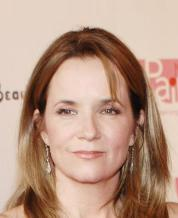

In [ ]:
showed_img_idx = 12
img_path = img_paths[showed_img_idx]
img = Image.open(img_path)
img

In [ ]:
test_imgpath = img_paths[showed_img_idx]
test_dataset = ColorDataset([test_imgpath])
test_sample = next(iter(test_dataset))

## 6.3. Show each color channel separately

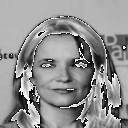

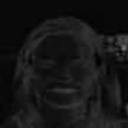

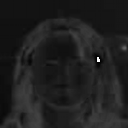

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

img_l, img_ab = test_sample

img_l = img_l.permute(1, 2, 0)
img_l = (img_l * 255).cpu().numpy().astype(np.uint8)
cv2_imshow(img_l)

img_a = img_ab[:1].permute(1, 2, 0)
img_a = (img_a * 255).cpu().numpy().astype(np.uint8)
cv2_imshow(img_a)

img_b = img_ab[1:].permute(1, 2, 0)
img_b = (img_b * 255).cpu().numpy().astype(np.uint8)
cv2_imshow(img_b)

### 6.4. Infering

In [ ]:
def inference(model, test_sample):
    with torch.no_grad():
        output, visuals = model.restoration(
            test_sample[0].unsqueeze(0).to(device)
        )
    return output, visuals

In [ ]:
output, visuals = inference(colordiff_model, test_sample)
print(output.shape)
print(visuals.shape)

torch.Size([1, 2, 128, 128])
torch.Size([21, 2, 128, 128])


### 6.5. Show the results

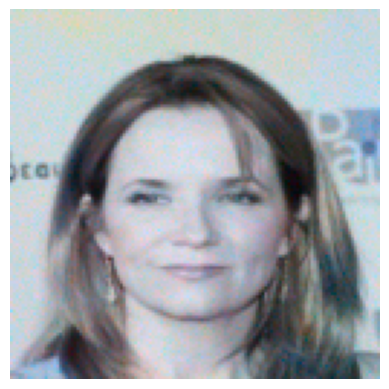

In [ ]:
def show_tensor_image(img_l, img_ab, is_save=False):
  a = torch.cat([img_l, img_ab], dim=0).permute(1, 2, 0).numpy()
  a = (a + 1.0) * 255 / 2
  a = np.clip(a, 0, 255).astype(np.uint8)
  b = cv2.cvtColor(a, cv2.COLOR_LAB2BGR)
  if is_save:
    cv2.imwrite("result_single_image.jpg", b)
  b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  plt.imshow(b)
  plt.axis(False)

show_tensor_image(test_sample[0], output[0].cpu(), is_save=True)
plt.show()

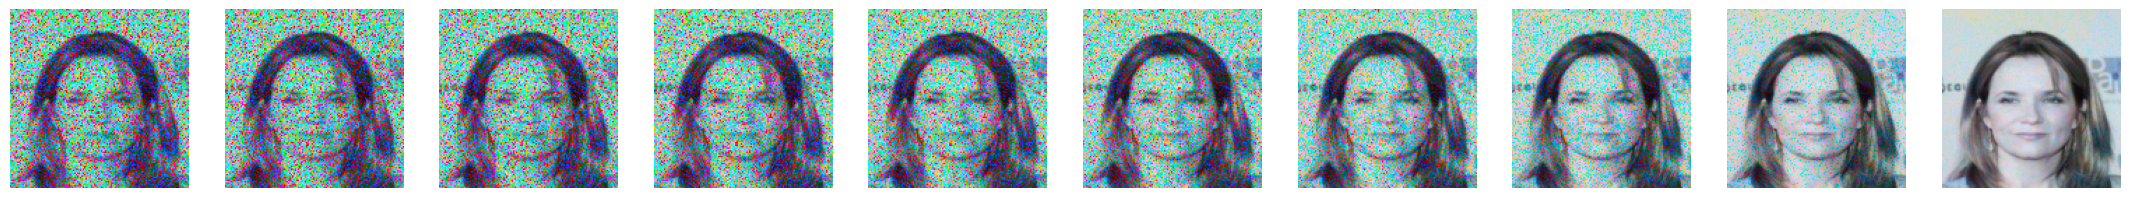

In [ ]:
num_images = len(visuals) // 2  # Assuming visuals contains both L and AB images
num_columns = min(num_images, 11)  # Ensure a maximum of 11 columns
num_rows = (num_images + num_columns - 1) // num_columns  # Calculate the number of rows

plt.figure(figsize=(num_columns * 3, num_rows * 3))  # Set the figure size based on columns and rows

count = 1
for i, visual in enumerate(visuals):
    if i % 2 == 0:
        continue
    plt.subplot(1, 11, count)
    count += 1
    show_tensor_image(test_sample[0], visual.cpu(), is_save=False)

plt.savefig("result_multi_image.png")
plt.show()